In [1]:
#naive forecaster

In [2]:
import pandas as pd
import numpy as np

In [16]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [7]:
uber = pd.read_csv('../uber_data.csv', parse_dates= True, index_col=0)
man = uber[uber['borough'] == 'Manhattan'].drop('borough', axis=1)
man

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
pickup_dt,,,,,,,,,,,
2015-01-01 01:00:00,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2015-01-01 02:00:00,4345,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,Y
2015-01-01 03:00:00,4577,5.0,10.0,30.0,8.0,1022.3,0.0,0.0,0.0,0.0,Y
2015-01-01 04:00:00,3003,5.0,10.0,29.0,9.0,1022.0,0.0,0.0,0.0,0.0,Y
2015-01-01 05:00:00,1313,5.0,10.0,28.0,9.0,1021.8,0.0,0.0,0.0,0.0,Y
...,...,...,...,...,...,...,...,...,...,...,...
2015-06-30 19:00:00,4585,5.0,10.0,80.0,58.0,1012.5,0.0,0.0,0.0,0.0,N
2015-06-30 20:00:00,4210,8.0,10.0,80.0,58.0,1012.4,0.0,0.0,0.0,0.0,N
2015-06-30 21:00:00,4313,7.0,10.0,76.0,61.0,1012.4,0.0,0.0,0.0,0.0,N


In [59]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa9f4884090>)

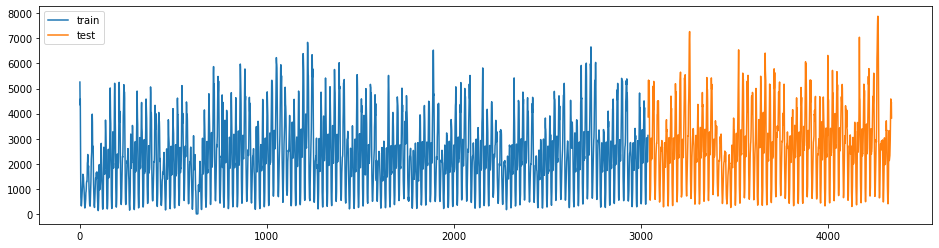

In [21]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting.forecasting import plot_ys

man = man.reset_index(drop = True)

train, test = temporal_train_test_split(man, test_size=0.3)

X_train = train.drop('pickups', axis=1)
y_train = train['pickups']

X_test = test.drop('pickups', axis=1)
y_test = test['pickups']

plot_ys(y_train,y_test, labels=['train','test'])

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa9f69d7650>)

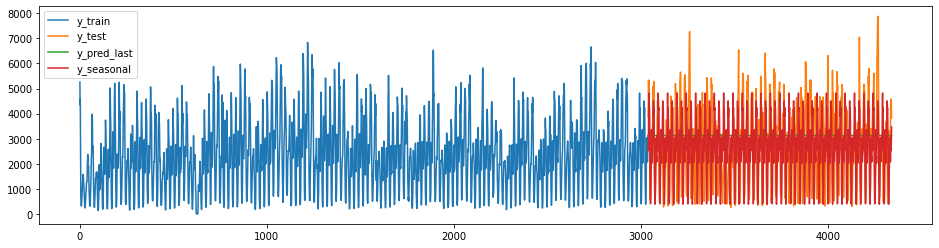

In [46]:
from sktime.forecasting.naive import NaiveForecaster

fh = np.arange(1,len(y_test)+1)

naive_forecaster_last = NaiveForecaster(strategy= "last")
naive_forecaster_last.fit(y_train)
y_last = naive_forecaster_last.predict(fh)

naive_forecaster_seasonal = NaiveForecaster(strategy='last', sp=50)
naive_forecaster_seasonal.fit(y_train)
y_seasonal = naive_forecaster_seasonal.predict(fh)



plot_ys(y_train,y_test,y_last,y_seasonal,labels=['y_train','y_test','y_pred_last','y_seasonal'])



In [47]:
from sktime.performance_metrics.forecasting import smape_loss
smape_loss(y_seasonal,y_test)

0.6516863965313078

0.6597866111518169

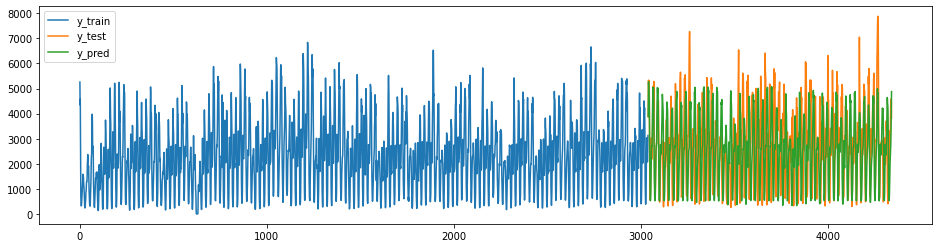

In [48]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
forecaster = ReducedRegressionForecaster(regressor,window_length=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_ys(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
smape_loss(y_test, y_pred)

In [60]:
smape_perso(y_test,y_pred)

65.97866111518165

In [58]:
y_t = pd.DataFrame(y_test[:169])
y_p = pd.DataFrame(y_pred[:169])

pd.concat([y_t,y_p]).plot()

Figure(id='1723', ...)

/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/base/m

0.4762069432600727

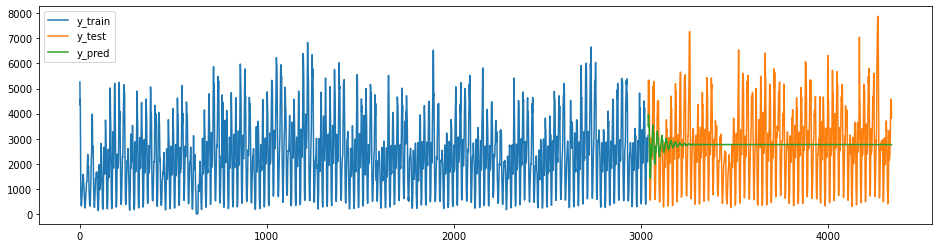

In [61]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [62]:
y_t = pd.DataFrame(y_test[:169])
y_p = pd.DataFrame(y_pred[:169])

pd.concat([y_t,y_p]).plot()

Figure(id='1896', ...)